<a href="https://colab.research.google.com/github/shubh8794/exponentia_datalabs_assignment/blob/master/Assignment_exponentia_datalabs_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

Objective is to create a model to predict remuneration of the vacancy/position in a data analytics firm.

In the train dataset, we have the input variables:

1. Experience
2. Job description
3. Job designation
4. Job Type
5. Key skills
6. Location
7. Salary
8. Company code

In the test dataset, we have all above variables except Salary (which we need to predict)
Apart from the output, also answer briefly, the following points:

1. Final variable list used in the model
2. Pre-processing variables, e.g. cleaning variables, re-classification of categories, creation of dummy variables, outlier treatment, imputed variables, changed variable datatype/ structure, etc.
3.  Model technique used
4. Variable importance/ strength/ contribution (if possible)
5. Any other information


In [0]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings("ignore")

In [0]:
#Reading train data
train_data = pd.read_csv("Train.csv")
print(train_data.shape)
train_data.head()

(19002, 8)


,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,5-7 yrs,Exp: Minimum 5 years;Good understanding of IOC...,Senior Exploit and Vulnerability Researcher,NaN,"team skills, communication skills, analytical ...",Delhi NCR(Vikas Puri),6to10,3687
1,10-17 yrs,He should have handled a team of atleast 5-6 d...,Head SCM,NaN,"ppc, logistics, inventory management, supply c...",Sonepat,10to15,458
2,5-9 yrs,Must be an effective communicator (written & s...,Deputy Manager - Talent Management & Leadershi...,Analytics,"HR Analytics, Employee Engagement, Training, S...",Delhi NCR,15to25,4195
3,7-10 yrs,7 - 10 years of overall experience in data e...,Associate Manager Data Engineering,Analytics,"SQL, Javascript, Automation, Python, Ruby, Ana...",Bengaluru,10to15,313
4,1-3 yrs,Chartered Accountancy degree or MBA in Finance...,TS- GSA- Senior Analyst,NaN,"accounting, finance, cash flow, financial plan...",Gurgaon,3to6,1305


**Before building model we need to perform some initial analysis and cleaning.**

In [0]:
# Eliminating duplicates records
train_data = train_data.drop_duplicates().reset_index(drop=True)
train_data.shape

(17715, 8)

In [0]:
train_data.isnull().sum()


experience                  0
job_description          4062
job_desig                   0
job_type                13805
key_skills                  1
location                    0
salary                      0
company_name_encoded        0
dtype: int64

Job description and job_type has lot of missing values. Since we are dealing with analytics companies so job_type will always be **analytics** and we will look into the missing values of job description later.

In [0]:
train_data['job_type'].value_counts()

Analytics    2960
analytics     839
ANALYTICS      68
analytic       27
Analytic       16
Name: job_type, dtype: int64

In [0]:
# Formating column values so that all of them will be same
train_data['job_type'] = "analytics"
train_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,5-7 yrs,Exp: Minimum 5 years;Good understanding of IOC...,Senior Exploit and Vulnerability Researcher,analytics,"team skills, communication skills, analytical ...",Delhi NCR(Vikas Puri),6to10,3687
1,10-17 yrs,He should have handled a team of atleast 5-6 d...,Head SCM,analytics,"ppc, logistics, inventory management, supply c...",Sonepat,10to15,458
2,5-9 yrs,Must be an effective communicator (written & s...,Deputy Manager - Talent Management & Leadershi...,analytics,"HR Analytics, Employee Engagement, Training, S...",Delhi NCR,15to25,4195
3,7-10 yrs,7 - 10 years of overall experience in data e...,Associate Manager Data Engineering,analytics,"SQL, Javascript, Automation, Python, Ruby, Ana...",Bengaluru,10to15,313
4,1-3 yrs,Chartered Accountancy degree or MBA in Finance...,TS- GSA- Senior Analyst,analytics,"accounting, finance, cash flow, financial plan...",Gurgaon,3to6,1305


In [0]:
train_data['salary'].value_counts()

10to15    4148
15to25    3457
6to10     3409
0to3      3078
3to6      2437
25to50    1186
Name: salary, dtype: int64

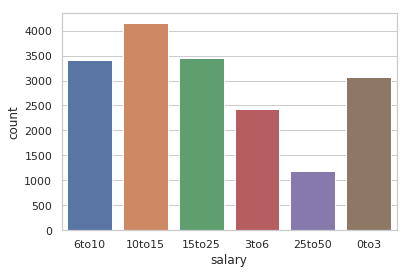

In [0]:
sns.countplot(x="salary", data=train_data)
plt.show()

In [0]:
def split_and_calculate_avg(value):
  first = value.split("-")[0]
  second = value.split("-")[1]
  average = (float(first) + float(second))/2
  return average

In [0]:
#formating experience column data into a fixed number
train_data['experience'] = train_data['experience'].str.replace(" yrs", "")
train_data['experience'] = train_data['experience'].apply(split_and_calculate_avg)
train_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,6.0,Exp: Minimum 5 years;Good understanding of IOC...,Senior Exploit and Vulnerability Researcher,analytics,"team skills, communication skills, analytical ...",Delhi NCR(Vikas Puri),6to10,3687
1,13.5,He should have handled a team of atleast 5-6 d...,Head SCM,analytics,"ppc, logistics, inventory management, supply c...",Sonepat,10to15,458
2,7.0,Must be an effective communicator (written & s...,Deputy Manager - Talent Management & Leadershi...,analytics,"HR Analytics, Employee Engagement, Training, S...",Delhi NCR,15to25,4195
3,8.5,7 - 10 years of overall experience in data e...,Associate Manager Data Engineering,analytics,"SQL, Javascript, Automation, Python, Ruby, Ana...",Bengaluru,10to15,313
4,2.0,Chartered Accountancy degree or MBA in Finance...,TS- GSA- Senior Analyst,analytics,"accounting, finance, cash flow, financial plan...",Gurgaon,3to6,1305


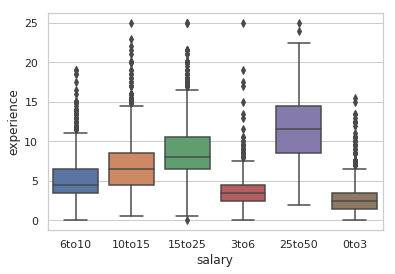

In [0]:
sns.boxplot(x="salary", y="experience", data=train_data)

In [0]:
Q1 = train_data.groupby(['salary'])['experience'].quantile(0.25)
Q3 = train_data.groupby(['salary'])['experience'].quantile(0.75)
IQR = Q3 - Q1
IQR_dict = IQR.to_dict()
IQR_dict

{'0to3': 2.0,
 '10to15': 4.0,
 '15to25': 4.0,
 '25to50': 6.0,
 '3to6': 2.0,
 '6to10': 3.0}

In [0]:
outlier_index = []
for i, row in train_data.iterrows():  
  if (row['experience'] < (Q1.to_dict().get(row['salary'])) - (1.5 * IQR_dict.get(row['salary']))) | (row['experience'] > (Q3.to_dict().get(row['salary'])) + (1.5 * IQR_dict.get(row['salary']))):
    outlier_index.append(i)                                                                           

In [0]:
train_data.drop(outlier_index,axis=0, inplace=True)
train_data.reset_index(drop=True).head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,6.0,Exp: Minimum 5 years;Good understanding of IOC...,Senior Exploit and Vulnerability Researcher,analytics,"team skills, communication skills, analytical ...",Delhi NCR(Vikas Puri),6to10,3687
1,13.5,He should have handled a team of atleast 5-6 d...,Head SCM,analytics,"ppc, logistics, inventory management, supply c...",Sonepat,10to15,458
2,7.0,Must be an effective communicator (written & s...,Deputy Manager - Talent Management & Leadershi...,analytics,"HR Analytics, Employee Engagement, Training, S...",Delhi NCR,15to25,4195
3,8.5,7 - 10 years of overall experience in data e...,Associate Manager Data Engineering,analytics,"SQL, Javascript, Automation, Python, Ruby, Ana...",Bengaluru,10to15,313
4,2.0,Chartered Accountancy degree or MBA in Finance...,TS- GSA- Senior Analyst,analytics,"accounting, finance, cash flow, financial plan...",Gurgaon,3to6,1305


In [0]:
def split_and_calculate_avg_salary(value):
  first = value.split("to")[0]
  second = value.split("to")[1]
  average = (float(first) + float(second))/2
  return average

In [0]:
#formating salary column data into a fixed number
train_data['salary'] = train_data['salary'].apply(split_and_calculate_avg_salary)
train_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,6.0,Exp: Minimum 5 years;Good understanding of IOC...,Senior Exploit and Vulnerability Researcher,analytics,"team skills, communication skills, analytical ...",Delhi NCR(Vikas Puri),8.0,3687
1,13.5,He should have handled a team of atleast 5-6 d...,Head SCM,analytics,"ppc, logistics, inventory management, supply c...",Sonepat,12.5,458
2,7.0,Must be an effective communicator (written & s...,Deputy Manager - Talent Management & Leadershi...,analytics,"HR Analytics, Employee Engagement, Training, S...",Delhi NCR,20.0,4195
3,8.5,7 - 10 years of overall experience in data e...,Associate Manager Data Engineering,analytics,"SQL, Javascript, Automation, Python, Ruby, Ana...",Bengaluru,12.5,313
4,2.0,Chartered Accountancy degree or MBA in Finance...,TS- GSA- Senior Analyst,analytics,"accounting, finance, cash flow, financial plan...",Gurgaon,4.5,1305


Cleaning the text in columns such as job_description, job_desig, key_skills and location to get rid of non-relevant words, punctuations, numbers.

In [0]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_string(input_string):
  try:
    alpha_string = re.sub('[^a-zA-Z]',' ', input_string)
    lowered_string = alpha_string.lower()
    lowered_string = lowered_string.split()
    cleared_string = [word for word in lowered_string if not word in set(stopwords.words('english'))]
    cleared_string = ' '.join(cleared_string)
    return cleared_string
  except:
    return ""
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
train_data[["job_description", "job_desig", "key_skills", "location"]] = train_data[["job_description", "job_desig", "key_skills", "location"]].applymap(clean_string)
train_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,6.0,exp minimum years good understanding ioc rules...,senior exploit vulnerability researcher,analytics,team skills communication skills analytical sk...,delhi ncr vikas puri,8.0,3687
1,13.5,handled team atleast direct reportees mechanic...,head scm,analytics,ppc logistics inventory management supply chai...,sonepat,12.5,458
2,7.0,must effective communicator written spoken str...,deputy manager talent management leadership de...,analytics,hr analytics employee engagement training succ...,delhi ncr,20.0,4195
3,8.5,years overall experience data engineering big ...,associate manager data engineering,analytics,sql javascript automation python ruby analytic...,bengaluru,12.5,313
4,2.0,chartered accountancy degree mba finance premi...,ts gsa senior analyst,analytics,accounting finance cash flow financial plannin...,gurgaon,4.5,1305


In [0]:
# train_data['key_skills'] = train_data['key_skills'].fillna('')
# train_data["key_skills"] = train_data['key_skills'].apply(lambda x : x.lower())
# train_data["key_skills"] = train_data['key_skills'].apply(lambda x : x.split(','))
# train_data["key_skills"] = train_data['key_skills'].apply(lambda x : ' '.join(x))
# train_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,salary,company_name_encoded
0,6.0,exp minimum years good understanding ioc rules...,senior exploit vulnerability researcher,analytics,team skills communication skills analytical ...,delhi ncr vikas puri,6to10,3687
1,13.5,handled team atleast direct reportees mechanic...,head scm,analytics,ppc logistics inventory management supply c...,sonepat,10to15,458
2,7.0,must effective communicator written spoken str...,deputy manager talent management leadership de...,analytics,hr analytics employee engagement training s...,delhi ncr,15to25,4195
3,8.5,years overall experience data engineering big ...,associate manager data engineering,analytics,sql javascript automation python ruby ana...,bengaluru,10to15,313
4,2.0,chartered accountancy degree mba finance premi...,ts gsa senior analyst,analytics,accounting finance cash flow financial plan...,gurgaon,3to6,1305


**Data Exploration**

1. Salary might varies with job location. Salary might be higher in one city and lower in other. 

2. Salary must depends on job designation. Senior positions must have higher salary

3. Salary should varies with the skills. Top skill candidate with with relevant years of experience have potentially higher salary.

4. Salaries should have positive correlation with experience. 



8.0


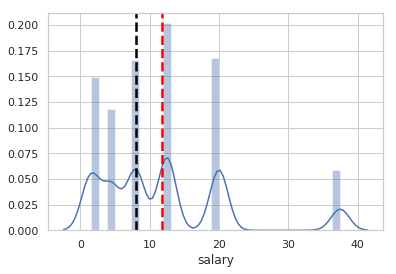

In [0]:
#Plot salary frequency and median and mean salary
ax = sns.distplot(train_data["salary"])
ax.axvline(train_data["salary"].median(), lw=2.5, ls='dashed', color='black')
ax.axvline(train_data["salary"].mean(), lw=2.5, ls='dashed', color='red')
med_salary = train_data["salary"].median()
print(med_salary)
train_data['above_med_salary'] = train_data['salary'].apply(lambda x : 1 if x > med_salary else 0)

In [0]:
# Populate sparse matrix for locations in each category
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = .05, ngram_range=(1, 3))
cv.fit(train_data["location"])
job_train = pd.DataFrame(cv.transform(train_data["location"]).todense(),
                       columns=cv.get_feature_names())
word_observe = pd.concat([job_train, train_data['above_med_salary']], axis=1)
word_observe.head()

,bengaluru,chennai,delhi,delhi ncr,gurgaon,hyderabad,mumbai,ncr,noida,pune,above_med_salary
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#most common location for above median salary
word_count = word_observe[word_observe["above_med_salary"]==1].sum(axis=0)
cw = word_count.sort_values(ascending = False).head(5)
good_locations = cw[1:].index.tolist()
good_locations

['bengaluru', 'mumbai', 'gurgaon', 'delhi']

In [0]:
train_data2 = train_data[['location', 'salary', 'key_skills', 'job_description', 'job_desig', 'experience']]
train_data2['good_city'] = 0
for index, row in train_data2.iterrows():
  if any(location in row['location'] for location in good_locations):
    train_data2.at[index,'good_city'] = 1


In [0]:
train_data2.head()

,location,salary,key_skills,job_description,job_desig,experience,good_city
0,delhi ncr vikas puri,8.0,team skills communication skills analytical sk...,exp minimum years good understanding ioc rules...,senior exploit vulnerability researcher,6.0,1
1,sonepat,12.5,ppc logistics inventory management supply chai...,handled team atleast direct reportees mechanic...,head scm,13.5,0
2,delhi ncr,20.0,hr analytics employee engagement training succ...,must effective communicator written spoken str...,deputy manager talent management leadership de...,7.0,1
3,bengaluru,12.5,sql javascript automation python ruby analytic...,years overall experience data engineering big ...,associate manager data engineering,8.5,1
4,gurgaon,4.5,accounting finance cash flow financial plannin...,chartered accountancy degree mba finance premi...,ts gsa senior analyst,2.0,1


In [0]:
# Populate sparse matrix for skills in each category
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = .05, ngram_range=(1, 3))
cv.fit(train_data["key_skills"])
job_train = pd.DataFrame(cv.transform(train_data["key_skills"]).todense(),
                       columns=cv.get_feature_names())
word_observe = pd.concat([job_train, train_data['above_med_salary']], axis=1)
word_observe.head()

,analysis,analyst,analytics,business,data,development,finance,financial,java,learning,management,marketing,process,python,research,sales,sas,sql,above_med_salary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#most common skills for above median salary
word_count = word_observe[word_observe["above_med_salary"]==1].sum(axis=0)
cw = word_count.sort_values(ascending = False).head(5)
good_skills = cw[1:].index.tolist()

In [0]:
train_data2['good_skills'] = 0
for index, row in train_data2.iterrows():
  if any(skill in row['key_skills'] for skill in good_skills):
    train_data2.at[index,'good_skills'] = 1
train_data2.head()

,location,salary,key_skills,job_description,job_desig,experience,good_city,good_skills
0,delhi ncr vikas puri,8.0,team skills communication skills analytical sk...,exp minimum years good understanding ioc rules...,senior exploit vulnerability researcher,6.0,1,0
1,sonepat,12.5,ppc logistics inventory management supply chai...,handled team atleast direct reportees mechanic...,head scm,13.5,0,1
2,delhi ncr,20.0,hr analytics employee engagement training succ...,must effective communicator written spoken str...,deputy manager talent management leadership de...,7.0,1,1
3,bengaluru,12.5,sql javascript automation python ruby analytic...,years overall experience data engineering big ...,associate manager data engineering,8.5,1,1
4,gurgaon,4.5,accounting finance cash flow financial plannin...,chartered accountancy degree mba finance premi...,ts gsa senior analyst,2.0,1,0


In [0]:
# Populate sparse matrix for job description in each category
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = .05, ngram_range=(1, 3))
cv.fit(train_data["job_description"])
job_train = pd.DataFrame(cv.transform(train_data["job_description"]).todense(),
                       columns=cv.get_feature_names())
word_observe = pd.concat([job_train, train_data['above_med_salary']], axis=1)
word_observe.head()
word_observe.columns.values.tolist()

['business',
 'data',
 'experience',
 'good',
 'knowledge',
 'must',
 'skills',
 'work',
 'working',
 'years',
 'years experience',
 'above_med_salary']

**Job description** contains words that are too generic will not add additional information to our model. 

In [0]:
# Populate sparse matrix for job designation in each category
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = .05, ngram_range=(1, 3))
cv.fit(train_data["job_desig"])
job_train = pd.DataFrame(cv.transform(train_data["job_desig"]).todense(),
                       columns=cv.get_feature_names())
word_observe = pd.concat([job_train, train_data['above_med_salary']], axis=1)
word_observe.head()

,analyst,analytics,business,data,developer,engineer,executive,manager,senior,above_med_salary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [0]:
#most common desig for above median salary
word_count = word_observe[word_observe["above_med_salary"]==1].sum(axis=0)
cw = word_count.sort_values(ascending = False).head(5)
good_desig = cw[1:].index.tolist()
good_desig

['analyst', 'manager', 'senior', 'data']

In [0]:
train_data2['good_desig'] = 0
for index, row in train_data2.iterrows():
  if any(desig in row['job_desig'] for desig in good_desig):
    train_data2.at[index,'good_desig'] = 1
train_data2.head()

,location,salary,key_skills,job_description,job_desig,experience,good_city,good_skills,good_desig
0,delhi ncr vikas puri,8.0,team skills communication skills analytical sk...,exp minimum years good understanding ioc rules...,senior exploit vulnerability researcher,6.0,1,0,1
1,sonepat,12.5,ppc logistics inventory management supply chai...,handled team atleast direct reportees mechanic...,head scm,13.5,0,1,0
2,delhi ncr,20.0,hr analytics employee engagement training succ...,must effective communicator written spoken str...,deputy manager talent management leadership de...,7.0,1,1,1
3,bengaluru,12.5,sql javascript automation python ruby analytic...,years overall experience data engineering big ...,associate manager data engineering,8.5,1,1,1
4,gurgaon,4.5,accounting finance cash flow financial plannin...,chartered accountancy degree mba finance premi...,ts gsa senior analyst,2.0,1,0,1


In [0]:
train_data2['salary'] = train_data2['salary'].replace({8.0 : '6to10', 1.5 : '0to3', 4.5 : '3to6', 12.5: '10to15', 20.0 : '15to25', 37.5: '25to50'})
X = train_data2[['experience', 'good_city', 'good_skills', 'good_desig']].values
y = train_data2[['salary']].values

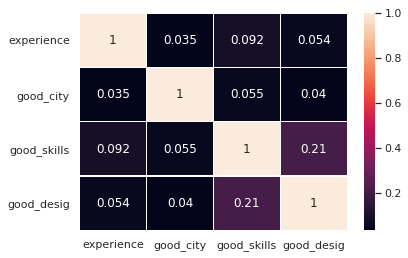

In [0]:
# Perform Pearson correlation coefficients using NumPy and Seaborn
feature_correlation_matrix = train_data2[['experience', 'good_city', 'good_skills', 'good_desig']].corr()
#Creating heatmap correlation matrix of predictor coefficients.
sns.heatmap(feature_correlation_matrix,
           annot = True,
           linewidths = 0.5)

In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [0]:
# # Fitting Logistic Regression to the Training set
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train, y_train)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

In [0]:
# Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)
# cm

array([[428,  32,   2,   0,  24,  98],
       [ 70, 379, 167,   2,  14, 178],
       [ 23, 290, 243,  27,   4,  92],
       [  3,  39, 106,  70,   1,  13],
       [182, 107,   2,   0,  49, 150],
       [101, 242,  53,   0,  34, 251]])

In [0]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_test, y_pred)

In [0]:
test_data = pd.read_excel("Test.xlsx")
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded
0,2-3 yrs,Experience working with popular social media a...,Urgently Looking for SMO Expert,Analytics,"Website Analysis, Google Analytics, SMO, Blogs...","Delhi NCR, Faridabad",268
1,7-12 yrs,Experience with microservice based architectur...,Frontend-senior Developer (bangalore),NaN,"Javascript, Html5, Web Services, Java, Web Tec...",Bengaluru,4120
2,4-9 yrs,NaN,Senior SEO Analyst,Analytics,"SEO, Search Engine Marketing, Social Media Opt...",Chennai,3341
3,1-3 yrs,NaN,Walk-in Drive for Graphics Designer (Exp 1-3yrs),Analytics,"Photoshop, Indesign, Graphic Designing, Graphi...",Pune,3603
4,10-12 yrs,- Experience in defining and executing profess...,VP - Engineering - Product Startup - Iit/nit,NaN,"Project Management, Stakeholder Management, Te...",Bengaluru,4049


In [0]:
# Eliminating duplicates records
test_data = test_data.drop_duplicates().reset_index(drop=True)
test_data.shape

(788, 7)

In [0]:
test_data.isnull().sum()

experience                0
job_description         175
job_desig                 0
job_type                613
key_skills                0
location                  0
company_name_encoded      0
dtype: int64

In [0]:
# Formating column values so that all of them will be same
test_data['job_type'] = "analytics"
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded
0,2-3 yrs,Experience working with popular social media a...,Urgently Looking for SMO Expert,analytics,"Website Analysis, Google Analytics, SMO, Blogs...","Delhi NCR, Faridabad",268
1,7-12 yrs,Experience with microservice based architectur...,Frontend-senior Developer (bangalore),analytics,"Javascript, Html5, Web Services, Java, Web Tec...",Bengaluru,4120
2,4-9 yrs,NaN,Senior SEO Analyst,analytics,"SEO, Search Engine Marketing, Social Media Opt...",Chennai,3341
3,1-3 yrs,NaN,Walk-in Drive for Graphics Designer (Exp 1-3yrs),analytics,"Photoshop, Indesign, Graphic Designing, Graphi...",Pune,3603
4,10-12 yrs,- Experience in defining and executing profess...,VP - Engineering - Product Startup - Iit/nit,analytics,"Project Management, Stakeholder Management, Te...",Bengaluru,4049


In [0]:
#formating experience column data into a fixed number
test_data['experience'] = test_data['experience'].str.replace(" yrs", "")
test_data['experience'] = test_data['experience'].apply(split_and_calculate_avg)
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded
0,2.5,Experience working with popular social media a...,Urgently Looking for SMO Expert,analytics,"Website Analysis, Google Analytics, SMO, Blogs...","Delhi NCR, Faridabad",268
1,9.5,Experience with microservice based architectur...,Frontend-senior Developer (bangalore),analytics,"Javascript, Html5, Web Services, Java, Web Tec...",Bengaluru,4120
2,6.5,NaN,Senior SEO Analyst,analytics,"SEO, Search Engine Marketing, Social Media Opt...",Chennai,3341
3,2.0,NaN,Walk-in Drive for Graphics Designer (Exp 1-3yrs),analytics,"Photoshop, Indesign, Graphic Designing, Graphi...",Pune,3603
4,11.0,- Experience in defining and executing profess...,VP - Engineering - Product Startup - Iit/nit,analytics,"Project Management, Stakeholder Management, Te...",Bengaluru,4049


In [0]:
test_data[["job_description", "job_desig", "key_skills", "location"]] = test_data[["job_description", "job_desig", "key_skills", "location"]].applymap(clean_string)
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded
0,2.5,experience working popular social media advert...,urgently looking smo expert,analytics,website analysis google analytics smo blogs so...,delhi ncr faridabad,268
1,9.5,experience microservice based architecture min...,frontend senior developer bangalore,analytics,javascript html web services java web technolo...,bengaluru,4120
2,6.5,,senior seo analyst,analytics,seo search engine marketing social media optim...,chennai,3341
3,2.0,,walk drive graphics designer exp yrs,analytics,photoshop indesign graphic designing graphics ...,pune,3603
4,11.0,experience defining executing professional sof...,vp engineering product startup iit nit,analytics,project management stakeholder management tech...,bengaluru,4049


In [0]:
test_data['good_city'] = 0
for index, row in test_data.iterrows():
  if any(location in row['location'] for location in good_locations):
    test_data.at[index,'good_city'] = 1

In [0]:
test_data['good_skills'] = 0
for index, row in test_data.iterrows():
  if any(skill in row['key_skills'] for skill in good_skills):
    test_data.at[index,'good_skills'] = 1
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded,good_city,good_skills
0,2.5,experience working popular social media advert...,urgently looking smo expert,analytics,website analysis google analytics smo blogs so...,delhi ncr faridabad,268,1,1
1,9.5,experience microservice based architecture min...,frontend senior developer bangalore,analytics,javascript html web services java web technolo...,bengaluru,4120,1,0
2,6.5,,senior seo analyst,analytics,seo search engine marketing social media optim...,chennai,3341,0,1
3,2.0,,walk drive graphics designer exp yrs,analytics,photoshop indesign graphic designing graphics ...,pune,3603,0,0
4,11.0,experience defining executing professional sof...,vp engineering product startup iit nit,analytics,project management stakeholder management tech...,bengaluru,4049,1,1


In [0]:
test_data['good_desig'] = 0
for index, row in test_data.iterrows():
  if any(desig in row['job_desig'] for desig in good_desig):
    test_data.at[index,'good_desig'] = 1
test_data.head()

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded,good_city,good_skills,good_desig
0,2.5,experience working popular social media advert...,urgently looking smo expert,analytics,website analysis google analytics smo blogs so...,delhi ncr faridabad,268,1,1,0
1,9.5,experience microservice based architecture min...,frontend senior developer bangalore,analytics,javascript html web services java web technolo...,bengaluru,4120,1,0,1
2,6.5,,senior seo analyst,analytics,seo search engine marketing social media optim...,chennai,3341,0,1,1
3,2.0,,walk drive graphics designer exp yrs,analytics,photoshop indesign graphic designing graphics ...,pune,3603,0,0,0
4,11.0,experience defining executing professional sof...,vp engineering product startup iit nit,analytics,project management stakeholder management tech...,bengaluru,4049,1,1,0


In [0]:
X_test = test_data[['experience', 'good_city', 'good_skills', 'good_desig']].values        

In [0]:
y_pred = classifier.predict(X_test)
y_pred

array(['0to3', '15to25', '10to15', '0to3', '10to15', '10to15', '15to25',
       '0to3', '6to10', '0to3', '0to3', '10to15', '0to3', '10to15',
       '10to15', '10to15', '25to50', '25to50', '0to3', '0to3', '10to15',
       '0to3', '6to10', '3to6', '6to10', '6to10', '10to15', '10to15',
       '10to15', '3to6', '25to50', '6to10', '10to15', '10to15', '0to3',
       '10to15', '25to50', '10to15', '25to50', '0to3', '15to25', '0to3',
       '10to15', '6to10', '0to3', '0to3', '0to3', '10to15', '0to3',
       '6to10', '10to15', '10to15', '15to25', '10to15', '10to15', '0to3',
       '10to15', '6to10', '0to3', '10to15', '6to10', '10to15', '15to25',
       '6to10', '6to10', '15to25', '10to15', '10to15', '10to15', '10to15',
       '0to3', '6to10', '15to25', '10to15', '10to15', '0to3', '0to3',
       '15to25', '6to10', '25to50', '3to6', '10to15', '15to25', '15to25',
       '15to25', '10to15', '25to50', '6to10', '6to10', '25to50', '10to15',
       '15to25', '6to10', '6to10', '10to15', '6to10', '6to10',

In [0]:
final_output = pd.concat([test_data, pd.DataFrame(y_pred)], axis=1)
final_output = final_output.drop(['good_city', 'good_skills', 'good_desig'], axis=1)
final_output

,experience,job_description,job_desig,job_type,key_skills,location,company_name_encoded,0
0,2.5,experience working popular social media advert...,urgently looking smo expert,analytics,website analysis google analytics smo blogs so...,delhi ncr faridabad,268,0to3
1,9.5,experience microservice based architecture min...,frontend senior developer bangalore,analytics,javascript html web services java web technolo...,bengaluru,4120,15to25
2,6.5,,senior seo analyst,analytics,seo search engine marketing social media optim...,chennai,3341,10to15
3,2.0,,walk drive graphics designer exp yrs,analytics,photoshop indesign graphic designing graphics ...,pune,3603,0to3
4,11.0,experience defining executing professional sof...,vp engineering product startup iit nit,analytics,project management stakeholder management tech...,bengaluru,4049,10to15
5,7.5,anywhere years experience experience managing ...,tech lead full stack developer ruby rails mvc,analytics,javascript jquery css html phonegap angularjs ...,delhi,1993,10to15
6,7.5,,immediate erp openings cmmi level company chen...,analytics,design development development testing require...,chennai hyderabad,449,15to25
7,2.5,years industry experience working high perform...,technology analyst java c,analytics,data structures algorithms c core java design ...,bengaluru,2319,0to3
8,3.5,minimum years experience preferred bachelors d...,business analyst mnc,analytics,tableau business analyst data visualization da...,delhi,4817,6to10
9,2.5,,store logistics suply chain walk interview,analytics,communication skills analytical problem solvin...,delhi ncr jaipur lucknow,64,0to3
